In [19]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [3]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0
...,...,...,...,...,...,...,...,...,...,...
44000,35,UNI,Unicaja,2021-03-24,0.802000,0.822000,0.786500,0.819500,0.751219,2616012
44001,35,UNI,Unicaja,2021-03-23,0.770000,0.807500,0.762500,0.802500,0.735636,2436213
44002,35,UNI,Unicaja,2021-03-22,0.780000,0.780500,0.760000,0.764000,0.700343,1420069
44003,35,UNI,Unicaja,2021-03-30,0.867000,0.878500,0.855500,0.877500,0.804387,3028721


In [5]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

acciona_ene = df[df['empresa'] == 'Acciona Energia']

acciona_ene.shape

(684, 10)

In [6]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

acciona_ene = acciona_ene [['date','open','high','low','close','adj close']]

acciona_ene.shape

(684, 6)

In [7]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

acciona_ene['date'] = pd.to_datetime(acciona_ene['date'], format="%Y-%m-%d")

acciona_ene.info()

<class 'pandas.core.frame.DataFrame'>
Index: 684 entries, 1316 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       684 non-null    datetime64[ns]
 1   open       684 non-null    float64       
 2   high       684 non-null    float64       
 3   low        684 non-null    float64       
 4   close      684 non-null    float64       
 5   adj close  684 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 37.4 KB


In [8]:
# Paso 5: Ordenar el DF por fecha

acciona_ene.sort_values(by='date',ascending= True, inplace=True)

acciona_ene.head()

,date,open,high,low,close,adj close
1534,2021-07-05,29.500000,29.50,28.549999,29.000000,28.145775
1533,2021-07-06,29.100000,29.10,28.500000,28.790001,27.941961
1532,2021-07-07,28.790001,29.50,28.520000,29.500000,28.631046
1531,2021-07-08,29.480000,29.90,29.059999,29.900000,29.019264
1530,2021-07-09,29.950001,30.75,29.629999,30.600000,29.698645


In [9]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-07-05'
fecha_fin = '2024-03-01'

acciona_ene = acciona_ene[(acciona_ene['date'] >= fecha_inicio) & (acciona_ene['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

acciona_ene.shape

(684, 6)

In [10]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=acciona_ene['date'].min(), end=acciona_ene['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

acciona_ene = acciona_ene.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

acciona_ene = acciona_ene.rename(columns={'index': 'date'})

In [11]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

acciona_ene.head(10)

,date,open,high,low,close,adj close
0,2021-07-05,29.500000,29.500000,28.549999,29.000000,28.145775
1,2021-07-06,29.100000,29.100000,28.500000,28.790001,27.941961
2,2021-07-07,28.790001,29.500000,28.520000,29.500000,28.631046
3,2021-07-08,29.480000,29.900000,29.059999,29.900000,29.019264
4,2021-07-09,29.950001,30.750000,29.629999,30.600000,29.698645
5,2021-07-10,NaN,NaN,NaN,NaN,NaN
6,2021-07-11,NaN,NaN,NaN,NaN,NaN
7,2021-07-12,30.950001,30.950001,30.230000,30.540001,29.640411
8,2021-07-13,30.600000,30.760000,30.379999,30.450001,29.553064
9,2021-07-14,30.530001,30.530001,29.500000,30.330000,29.436598


In [12]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

acciona_ene = acciona_ene.fillna(method='ffill')

In [14]:
# Paso 10: Comprobar que se han introducido los valores correctamente


acciona_ene.head(10)

,date,open,high,low,close,adj close
0,2021-07-05,29.500000,29.500000,28.549999,29.000000,28.145775
1,2021-07-06,29.100000,29.100000,28.500000,28.790001,27.941961
2,2021-07-07,28.790001,29.500000,28.520000,29.500000,28.631046
3,2021-07-08,29.480000,29.900000,29.059999,29.900000,29.019264
4,2021-07-09,29.950001,30.750000,29.629999,30.600000,29.698645
5,2021-07-10,29.950001,30.750000,29.629999,30.600000,29.698645
6,2021-07-11,29.950001,30.750000,29.629999,30.600000,29.698645
7,2021-07-12,30.950001,30.950001,30.230000,30.540001,29.640411
8,2021-07-13,30.600000,30.760000,30.379999,30.450001,29.553064
9,2021-07-14,30.530001,30.530001,29.500000,30.330000,29.436598


In [16]:
# Paso 11: Establecer columna 'date' como índice para modelo

acciona_ene = acciona_ene.set_index('date')

acciona_ene.head(10)

,open,high,low,close,adj close
date,,,,,
2021-07-05,29.500000,29.500000,28.549999,29.000000,28.145775
2021-07-06,29.100000,29.100000,28.500000,28.790001,27.941961
2021-07-07,28.790001,29.500000,28.520000,29.500000,28.631046
2021-07-08,29.480000,29.900000,29.059999,29.900000,29.019264
2021-07-09,29.950001,30.750000,29.629999,30.600000,29.698645
2021-07-10,29.950001,30.750000,29.629999,30.600000,29.698645
2021-07-11,29.950001,30.750000,29.629999,30.600000,29.698645
2021-07-12,30.950001,30.950001,30.230000,30.540001,29.640411
2021-07-13,30.600000,30.760000,30.379999,30.450001,29.553064


In [17]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

acciona_ene.index = pd.DatetimeIndex(acciona_ene.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

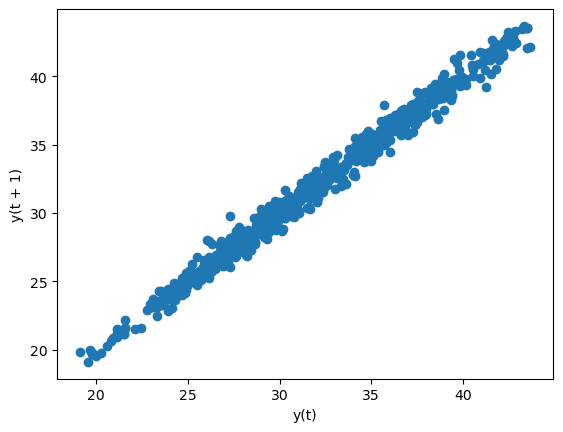

In [18]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(acciona_ene.close)

In [20]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [22]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = acciona_ene.close[:-10], acciona_ene.close[-10:]

train.shape, test.shape

((961,), (10,))

In [23]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [24]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(acciona_ene.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    20.862579
2024-02-22    20.885097
2024-02-23    20.907552
2024-02-24    20.929946
2024-02-25    20.952278
2024-02-26    20.974549
2024-02-27    20.996759
2024-02-28    21.018908
2024-02-29    21.040996
2024-03-01    21.063023
Freq: D, dtype: float64

In [25]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    20.600000
2024-02-22    20.280001
2024-02-23    19.780001
2024-02-24    19.780001
2024-02-25    19.780001
2024-02-26    19.690001
2024-02-27    19.969999
2024-02-28    19.559999
2024-02-29    19.100000
2024-03-01    19.790001
Freq: D, Name: close, dtype: float64

In [26]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

1.130168361553379

In [27]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,20.600000,20.862579,0.262579
2024-02-22,20.280001,20.885097,0.605096
2024-02-23,19.780001,20.907552,1.127551
2024-02-24,19.780001,20.929946,1.149945
2024-02-25,19.780001,20.952278,1.172277
2024-02-26,19.690001,20.974549,1.284548
2024-02-27,19.969999,20.996759,1.026760
2024-02-28,19.559999,21.018908,1.458909
2024-02-29,19.100000,21.040996,1.940996
2024-03-01,19.790001,21.063023,1.273022
